In [1]:
import pandas as pd 
import geopandas as gpd 

import matplotlib.pyplot as plt

from tqdm import tqdm 
from glob import glob 

import os
import sys 

In [2]:
PROJ_CRS = 'EPSG:2263'

In [3]:
DoCs = ["2023-08-11"]
traffic = [] 
for day in DoCs: 
    day_data = pd.read_csv(f"/share/ju/urbanECG/output/street_flooding/df/{day}/detections.csv", engine='pyarrow', index_col=0)[['0','1','2']].fillna(0)
    day_md = pd.read_csv(f"/share/ju/urbanECG/output/street_flooding/df/{day}/md.csv", engine='pyarrow', index_col=0)
    traffic.append(day_md.merge(day_data, left_on='frame_id', right_index=True))
    
traffic = pd.concat(traffic)



In [4]:
traffic = gpd.GeoDataFrame(traffic, geometry=gpd.points_from_xy(traffic['gps_info.longitude'], traffic['gps_info.latitude']), crs='EPSG:4326').to_crs(PROJ_CRS)

In [5]:
# load nyc sidewalks 
nyc_sidewalks = gpd.read_file("../data/Sidewalk.geojson").to_crs(PROJ_CRS)

In [6]:
nyc_sidewalks.shape_area = nyc_sidewalks.shape_area.astype(float)
nyc_sidewalks.shape_leng = nyc_sidewalks.shape_leng.astype(float)
nyc_sidewalks['shape_width'] = nyc_sidewalks.shape_area / nyc_sidewalks.shape_leng

In [7]:
# spatial join nearest 
traffic = gpd.sjoin_nearest(traffic, nyc_sidewalks, distance_col='distance_to_sidewalk', max_distance=50)

In [8]:
# get average traffic per sidewalk
# traffic is in 0, 1, 2 columns 
avg_traffic_by_sidewalk = traffic.groupby('source_id')[['0','1','2']].mean()
avg_traffic_by_sidewalk = nyc_sidewalks.merge(avg_traffic_by_sidewalk, left_on='source_id', right_index=True)

In [9]:
# created a 'crowdedness' metric that multiplies the number of people by a multiplier of relative to average sidewalk width
avg_traffic_by_sidewalk['rta_width'] = avg_traffic_by_sidewalk['shape_width'] / avg_traffic_by_sidewalk['shape_width'].mean()
avg_traffic_by_sidewalk['crowdedness'] = avg_traffic_by_sidewalk['rta_width'] * avg_traffic_by_sidewalk['0']

In [10]:
avg_traffic_by_sidewalk['rta_width'].describe()

count    33267.000000
mean         1.000000
std          0.278175
min          0.108650
25%          0.835077
50%          0.964395
75%          1.152468
max          7.536993
Name: rta_width, dtype: float64

In [11]:
avg_traffic_by_sidewalk['crowdedness'].describe()

count    33267.000000
mean         0.799926
std          1.358497
min          0.000000
25%          0.000000
50%          0.321948
75%          0.959976
max         28.292332
Name: crowdedness, dtype: float64

<Axes: >

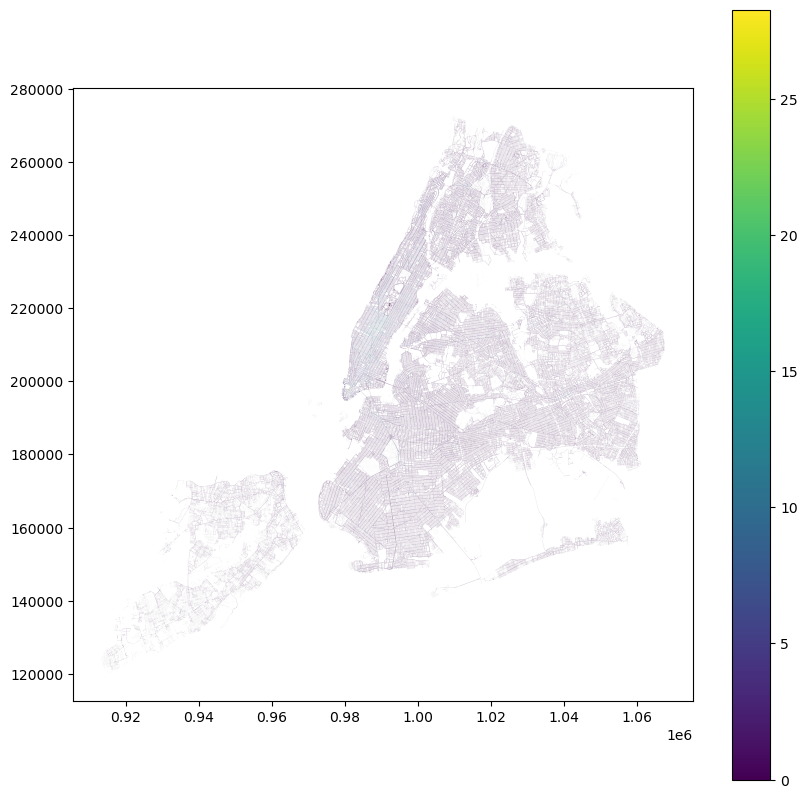

In [13]:
# map nyc sidewalks, color by 0
fig, ax = plt.subplots(figsize=(10,10))
nyc_sidewalks.plot(ax=ax, color='grey', alpha=0.5)
avg_traffic_by_sidewalk.plot(ax=ax, column='crowdedness', legend=True)

In [15]:
# write average traffic to disk 
avg_traffic_by_sidewalk.to_file("../data/avg_traffic_by_sidewalk.geojson", driver='GeoJSON')